# 2A.ml - Séries temporelles - correction

Prédictions sur des séries temporelles.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Une série temporelles

On récupère le nombre de sessions d'un site web.

In [3]:
import pandas
data = pandas.read_csv("xavierdupre_sessions.csv", sep="\t")
data.set_index("Date", inplace=True)
data.head()

,Sessions
Date,
28/10/2010,7
29/10/2010,6
30/10/2010,4
31/10/2010,6
01/11/2010,2


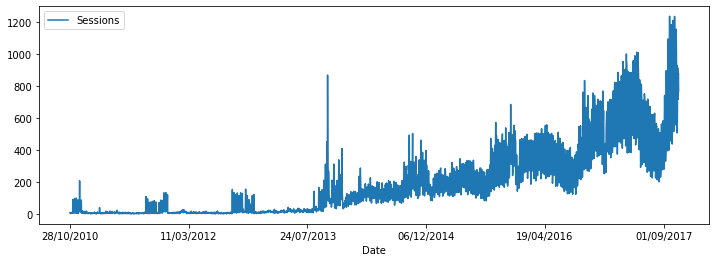

In [4]:
data.plot(figsize=(12,4));

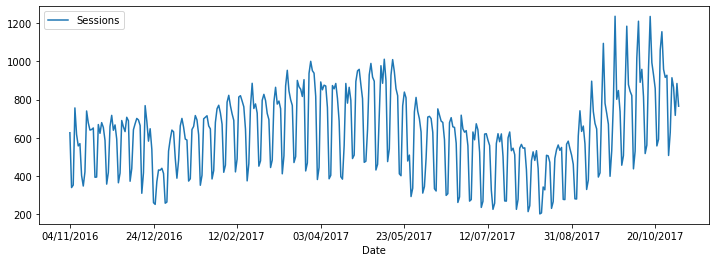

In [5]:
data[-365:].plot(figsize=(12,4));

## Trends

Fonction [detrend](http://www.statsmodels.org/dev/generated/statsmodels.tsa.tsatools.detrend.html#statsmodels.tsa.tsatools.detrend).

In [6]:
from statsmodels.tsa.tsatools import detrend
notrend = detrend(data['Sessions'])
data["notrend"] = notrend
data["trend"] = data['Sessions'] - notrend
data.tail()

,Sessions,notrend,trend
Date,,,
30/10/2017,914,367.387637,546.612363
31/10/2017,863,316.119822,546.880178
01/11/2017,717,169.852008,547.147992
02/11/2017,884,336.584193,547.415807
03/11/2017,765,217.316379,547.683621


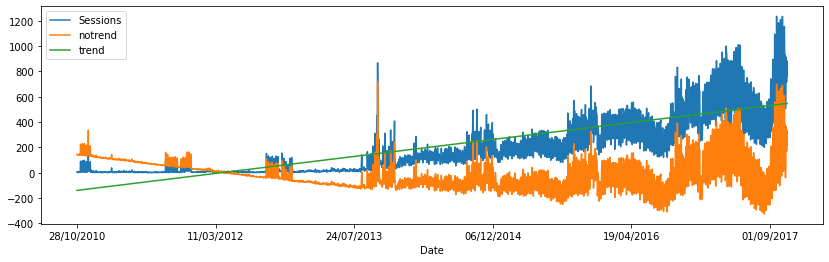

In [7]:
data.plot(y=["Sessions", "notrend", "trend"], figsize=(14,4));

On essaye de calculer une tendance en minimisant : $Y=\alpha + \beta t + \gamma t^2$.

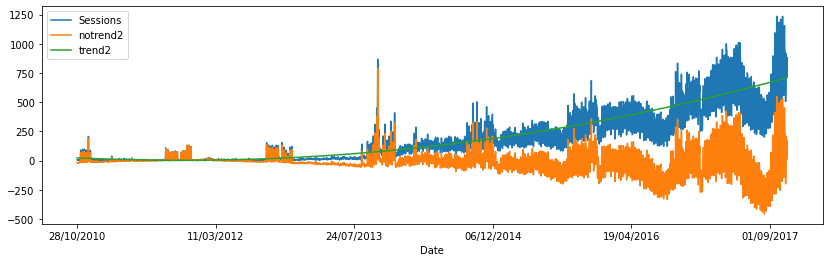

In [8]:
notrend2 = detrend(data['Sessions'], order=2)
data["notrend2"] = notrend2
data["trend2"] = data["Sessions"] - data["notrend2"]
data.plot(y=["Sessions", "notrend2", "trend2"], figsize=(14,4));

On passe au log.

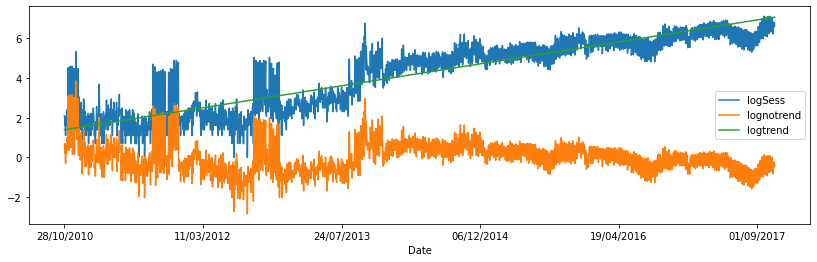

In [9]:
import numpy
data["logSess"] = data["Sessions"].apply(lambda x: numpy.log(x+1))
lognotrend = detrend(data['logSess'])
data["lognotrend"] = lognotrend
data["logtrend"] = data["logSess"] - data["lognotrend"]
data.plot(y=["logSess", "lognotrend", "logtrend"], figsize=(14,4));

La série est assez particulière. Elle donne l'impression d'avoir un changement de régime. On extrait la composante saisonnière avec [seasonal_decompose](http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels.tsa.seasonal.seasonal_decompose).

<ipython-input-23-986850a44b5e>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead.
  res = seasonal_decompose(data["Sessions"].values.ravel(), freq=7, two_sided=False)


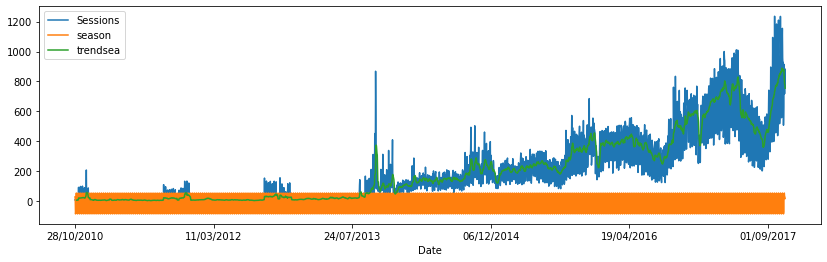

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(data["Sessions"].values.ravel(), freq=7, two_sided=False)
data["season"] = res.seasonal
data["trendsea"] = res.trend
data.plot(y=["Sessions", "season", "trendsea"], figsize=(14,4));

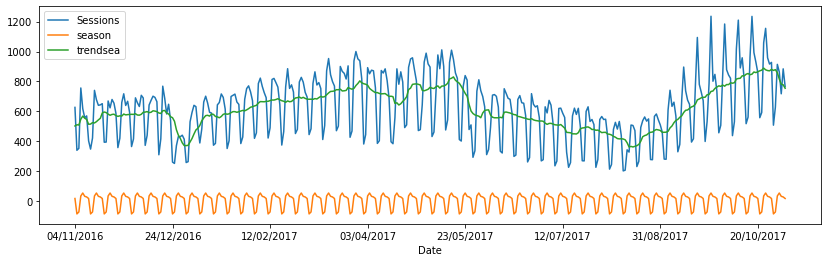

In [11]:
data[-365:].plot(y=["Sessions", "season", "trendsea"], figsize=(14,4));

<ipython-input-25-c64a8f19748f>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead.
  res = seasonal_decompose(data["Sessions"].values.ravel() + 1, freq=7,


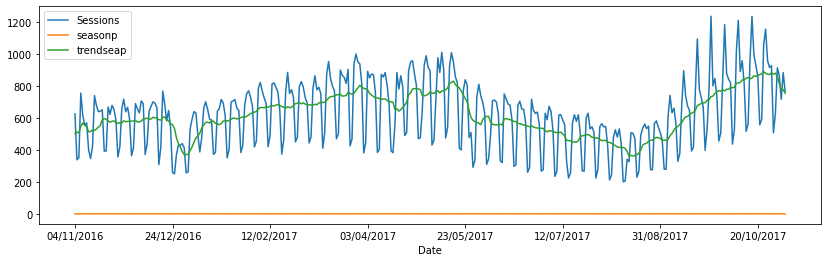

In [12]:
res = seasonal_decompose(data["Sessions"].values.ravel() + 1, freq=7,
                         two_sided=False, model='multiplicative')
data["seasonp"] = res.seasonal
data["trendseap"] = res.trend
data[-365:].plot(y=["Sessions", "seasonp", "trendseap"], figsize=(14,4));

## Enlever la saisonnalité sans la connaître

Avec [fit_seasons](https://github.com/welch/seasonal/blob/master/seasonal/seasonal.py#L25).

[ 26.66213008  16.33420353 -86.59519495 -73.57497492  33.23110565
  52.87820674  30.87516435]


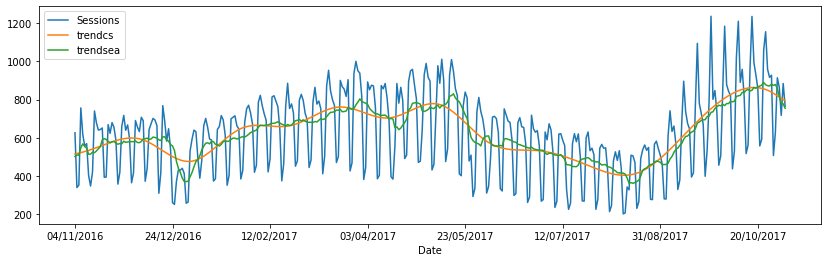

In [13]:
from seasonal import fit_seasons
cv_seasons, trend = fit_seasons(data["Sessions"])
print(cv_seasons)
# data["cs_seasons"] = cv_seasons
data["trendcs"] = trend
data[-365:].plot(y=["Sessions", "trendcs", "trendsea"], figsize=(14,4));

## Autocorrélograme

On s'inspire de l'exemple : [Autoregressive Moving Average (ARMA): Sunspots data](http://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html).

C:\Python395_x64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Python395_x64\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


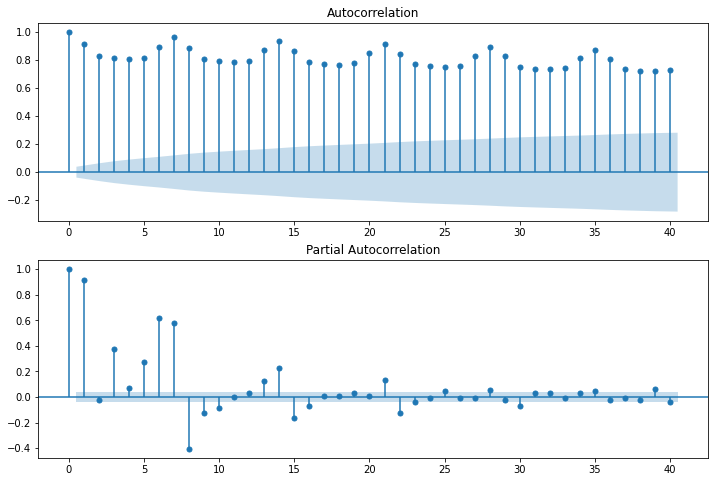

In [14]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data["Sessions"], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data["Sessions"], lags=40, ax=ax2);

On retrouve bien une période de 7.

## Changements de régime

* [Gaussian HMM of stock data](https://hmmlearn.readthedocs.io/en/latest/auto_examples/plot_hmm_stock_analysis.html#sphx-glr-auto-examples-plot-hmm-stock-analysis-py)
* [MixedLM](http://www.statsmodels.org/dev/generated/statsmodels.regression.mixed_linear_model.MixedLM.html)
* [RLM](http://www.statsmodels.org/dev/examples/notebooks/generated/robust_models_0.html)
* [Local Linear Trend](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_local_linear_trend.html)
* [MarkovAutoregression](http://www.statsmodels.org/dev/generated/statsmodels.tsa.regime_switching.markov_autoregression.MarkovAutoregression.html)